In [30]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

class DogsVSCats():
    # normalize the imgs
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS:0, DOGS:1}
    
    training_data =  []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try :
                    path = os.path.join(label,f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img) , np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1 
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
                    # print(str(e))
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)        
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [2]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [8]:
print(len(training_data))

24946


In [3]:
print(training_data[0])

[array([[195, 195, 193, ..., 137, 132, 126],
       [194, 195, 193, ..., 136, 130, 124],
       [196, 195, 193, ..., 135, 129, 125],
       ...,
       [186, 187, 185, ..., 165, 156, 150],
       [188, 188, 190, ..., 168, 160, 152],
       [190, 194, 197, ..., 171, 162, 154]], dtype=uint8)
 array([1., 0.])]


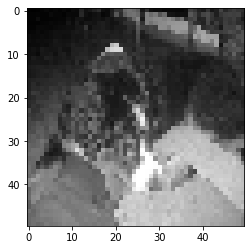

[0. 1.]


In [10]:
import matplotlib.pyplot as plt

plt.imshow(training_data[8][0] , cmap ="gray")
plt.show()
print(training_data[8][1])

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear )
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return F.softmax(x, dim=1)
        
net = Net()

torch.Size([128, 2, 2])


In [23]:
import torch.optim as optim

optimazer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [32]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [33]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

AttributeError: 'tqdm' object has no attribute 'pos'